### Import modules

In [1]:
cd

/home/jovyan


In [2]:
import datacube 
from datacube.virtual import catalog_from_file
dc = datacube.Datacube()

service = '/home/jovyan/development/'
from datacube.helpers import write_geotiff
import numpy as np
import sys
import xarray as xr
from itertools import groupby

sys.path.append("dev/dea-notebooks/Gabrielle_dev/Scripts")
from dea_plotting import rgb
from dea_plotting import display_map
from dea_bandindices import calculate_indices

# product = catalog['salty']
# data = product.load(dc, **query)
# (data.vssi.squeeze()).plot.imshow()

### Locations

### View the selected location

In [3]:
# Set the central latitude and longitude
central_lat = -12.220129
central_lon = 132.281712

# Set the buffer to load around the central coordinates
buffer = 0.1

# Compute the bounding box for the study area
study_area_lat = (central_lat - buffer, central_lat + buffer)
study_area_lon = (central_lon - buffer, central_lon + buffer)

display_map(x=study_area_lon, y=study_area_lat, margin=-0.2)

/env/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/env/lib/python3.6/site-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
/env/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: h

### Set parameters

In [4]:
# x = (350000, 400000)
# y = (-3500000, -3450000)

# Name
# area_name = 'Leichhardt'
x = study_area_lon#(min_x,max_x)
y = study_area_lat#(min_y,max_y)
res = (-100, 100)
crs = "EPSG:4326"
time = ("2015-01-01", "2015-12-31")
query =({'time': time,
             'x':x,
            'y':y,
            'crs':crs,
            'output_crs':'EPSG:3577',
            'resolution':res,
            'group_by': 'solar_day'})
catalog = catalog_from_file(str(service)+'livingearth_australia/le_plugins/virtual_product_cat.yaml')

### Add le plugins

In [6]:
import importlib
import sys
import os
from datacube.virtual import DEFAULT_RESOLVER
sys.path.append(os.path.abspath(str(service)+"livingearth_australia/le_plugins"))
sys.path.append(str(service)+"dea-notebooks/Scripts")
sys.path.append(str(service)+"livingearth_australia")

#see what's already in the resolver 
DEFAULT_RESOLVER.lookup_table['transform']

# Now we add the transformation we're testing
# Get location of transformation
transformation = "le_plugins.waterseasonality"
trans_loc = importlib.import_module(transformation)
trans_class = transformation.split('.')[-1]
DEFAULT_RESOLVER.register('transform', trans_class, getattr(trans_loc, trans_class) )

In [7]:
#see what's now in the resolver 
DEFAULT_RESOLVER.lookup_table['transform']

{'make_mask': datacube.virtual.transformations.MakeMask,
 'apply_mask': datacube.virtual.transformations.ApplyMask,
 'to_float': datacube.virtual.transformations.ToFloat,
 'rename': datacube.virtual.transformations.Rename,
 'select': datacube.virtual.transformations.Select,
 'expressions': datacube.virtual.transformations.Expressions,
 'waterseasonality': le_plugins.waterseasonality.waterseasonality}

### Load data
`ls_fc_wofs_masked_recipe` and `wofs_daily_recipe` both go into FC_summary

In [8]:
product = catalog['ls_ard_daily']
data = product.load(dc, **query)

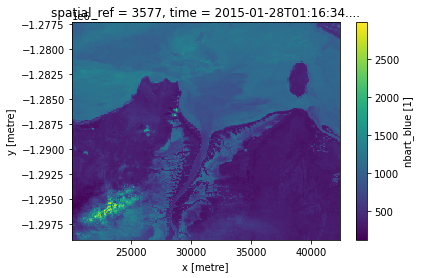

In [9]:
data.isel(time=1).nbart_blue.plot()

### Annual TCW based on daily data not geomedian

In [ ]:
### Consecutive count
def consecutive_count(water_numpy, consecutive_numpy, required_consecutive, consec_msk_val=1):
    '''
    function to get consective count of wet vegetation (1) for each pixel across the time series

    :param numpy.array water_numpy: 3-D array of tv[z,y,x]
    :param numpy.array consecutive_numpy: bool output array for wet vegetation (1) and not wet vegetation (0)
    :param float required_consecutive: how many consectutive 1's to be classified as wet vegetation?
    :param float consec_msk_val: what value to calculcate consectutives on default is wet vegetation (1)     
    '''

    for y in range(water_numpy.shape[1]):
        for x in range(water_numpy.shape[2]):
            # If all the values are nan then just set output to nan and carry on
            pixel = water_numpy[:,y,x]

            if np.all(np.isnan(pixel)):
                consecutive_numpy[y,x] = np.nan
                continue            

            # Get counts of consecutive water classifications
            counts = [len(list(group)) for label, group in groupby(pixel[(~np.isnan(pixel))]) if label == 1]

            if not counts:
                consecutive_numpy[y,x] = 0
            elif max(counts) >= required_consecutive:
                consecutive_numpy[y,x] = 1
            else:
                consecutive_numpy[y,x] = 0

    return consecutive_numpy

def compute(data):
    # Calculate daily TCW
    tcw = calculate_indices(data,
                            index='TCW', 
                            collection='ga_ls_3',
                            drop=True,
                            normalise=False)

    # Calculate wet pixels - daily boolean 
    wet = (tcw.TCW > -600).to_dataset()

    # Group by month - total number of observations
    wet_month = wet.groupby('time.month').sum(dim='time')  

    # Now if at least one time was observed as wet make it 1 (end result is boolean per month)
    wet_once = wet_month.TCW >= 1

    # reduce original array to 2D
    # using max here but not important as we just want to use shape/attributes
    wet_reduce = wet_once.max(dim='month')

    # Make empty monthly array
    watersea = copy.deepcopy(wet_reduce)
    watersea.values = np.zeros_like(wet_reduce, dtype='float64')
    # print('watersea',watersea)

    # Get ready for consecutive count
    wet_numpy = wet_once.values
    empty_numpy = watersea.values

    # Required consecutive
    required_consecutive = 2

    # Calculate consecutive counts
    consec = self.consecutive_count(wet_numpy, empty_numpy, required_consecutive)

    # create new data array with sampe dimensions as original
    wet_summary = xr.DataArray(consec, coords=wet_reduce.coords, dims=wet_reduce.dims)

    # just a check
    result = wet_summary.to_dataset(name='annual_tcw').squeeze()
    print()
    print('annual_tcw result',result)

In [10]:
def consecutive_count(water_numpy, consecutive_numpy, required_consecutive, consec_msk_val=1):
    '''
    function to get consective count of water (1) for each pixel across the time series

    :param numpy.array water_numpy: 3-D array of tv[z,y,x]
    :param numpy.array consecutive_numpy: bool output array for water (1) and not water (0)
    :param float required_consecutive: how many consectutive 1's to be classified as water?
    :param float consec_msk_val: what value to calculcate consectutives on
           default is water (1)     
    '''

    for y in range(water_numpy.shape[1]):
        for x in range(water_numpy.shape[2]):
            # If all the values are nan then just set output to nan and carry on
            pixel = water_numpy[:,y,x]

            if np.all(np.isnan(pixel)):
                consecutive_numpy[y,x] = np.nan
                continue            

            # Get counts of consecutive water classifications
            counts = [len(list(group)) for label, group in groupby(pixel[(~np.isnan(pixel))]) if label == 1]

            if not counts:
                consecutive_numpy[y,x] = 0
            elif max(counts) >= required_consecutive:
                consecutive_numpy[y,x] = max(counts)
            else:
                consecutive_numpy[y,x] = 0

    return consecutive_numpy

### Water seasonality

In [11]:
### Cosnecutive count

def consecutive_count(water_numpy, consecutive_numpy, required_consecutive, consec_msk_val=1):
    '''
    function to get consective count of water (1) for each pixel across the time series

    :param numpy.array water_numpy: 3-D array of tv[z,y,x]
    :param numpy.array consecutive_numpy: bool output array for water (1) and not water (0)
    :param float required_consecutive: how many consectutive 1's to be classified as water?
    :param float consec_msk_val: what value to calculcate consectutives on
           default is water (1)     
    '''

    for y in range(water_numpy.shape[1]):
        for x in range(water_numpy.shape[2]):
            # If all the values are nan then just set output to nan and carry on
            pixel = water_numpy[:,y,x]

            if np.all(np.isnan(pixel)):
                consecutive_numpy[y,x] = np.nan
                continue            

            # Get counts of consecutive water classifications
            counts = [len(list(group)) for label, group in groupby(pixel[(~np.isnan(pixel))]) if label == 1]

            if not counts:
                consecutive_numpy[y,x] = 0
            elif max(counts) >= required_consecutive:
                consecutive_numpy[y,x] = 1
            else:
                consecutive_numpy[y,x] = 0

    return consecutive_numpy

### Actually calculate

# print('Data in water seasonality',data)
# Calculate daily TCW
tcw = calculate_indices(data,
                        index='TCW', 
                        collection='ga_ls_3',
                        drop=True,
                        normalise=False)
# print('tcw',tcw)
# tcw.isel(time=1).TCW.plot()

# Calculate wet pixels - daily boolean 
wet = (tcw.TCW > -600).to_dataset()
# print('wet',wet)
# wet.isel(time=1).TCW.plot()

# Group by month - total number of observations
wet_month = wet.groupby('time.month').sum(dim='time')  
# print('wet_month',wet_month)
# wet_month.isel(month=2).TCW.plot()

# Now if at least one time was observed as wet make it 1 (end result is boolean per month)
wet_once = wet_month.TCW >= 1
# print('wet_once',wet_once) 
# wet_once.isel(month=2).plot()

# # Calculate total number of inundated months
# wet_months = wet_once.sum(dim='month')
# # print('wet months',wet_months)
# # wet_months.plot()

# reduce original array to 2D
# using max here but not important as we just want to use shape/attributes
wet_reduce = wet_once.max(dim='month')

# Make empty monthly array
watersea = copy.deepcopy(wet_reduce)
watersea.values = np.zeros_like(wet_reduce, dtype='float64')
# print('watersea',watersea)

# Get ready for consecutive count
wet_numpy = wet_once.values
empty_numpy = watersea.values

# Required consecutive
required_consecutive = 2

# Calculate consecutive counts
consec = consecutive_count(wet_numpy, empty_numpy, required_consecutive)
# print('consec',consec.shape)
# plt.imshow(consec)
# plt.colorbar()

# create new data array with sampe dimensions as original
wet_summary = xr.DataArray(consec, coords=wet_reduce.coords, dims=wet_reduce.dims)
print('wet_summary',wet_summary)
wet_summary.plot()

# # using wet_months to seperate Water < 3 months (<= 0.25) and Water > 3 months (> 0.25)
# watersea.values = np.where(((wet_summary > 0) & (wet_summary <= 3)), 2, watersea.values)
# watersea.values = np.where(((wet_summary > 3) & (wet_summary <= 12)), 1, watersea.values)
# # print('watersea',watersea)
# watersea.plot()

result = wet_summary.to_dataset(name='annual_tcw').squeeze()
print('result',result)

Dropping bands ['nbart_blue', 'nbart_green', 'nbart_red', 'nbart_nir', 'nbart_swir_1', 'nbart_swir_2']


dev/dea-notebooks/Gabrielle_dev/Scripts/dea_bandindices.py:268: UserWarning: 
A coefficient-based index ('TCW') normally applied to surface reflectance values in the 
0.0-1.0 range was applied to values in the 0-10000 range. This can produce unexpected results; 
if required, resolve this by setting `normalise=True`
  warnings.warn(f"\nA coefficient-based index ('{index}') normally "


NameError: name 'copy' is not defined

In [19]:
import copy
import matplotlib.pyplot as plt

Dropping bands ['nbart_blue', 'nbart_green', 'nbart_red', 'nbart_nir', 'nbart_swir_1', 'nbart_swir_2']
result <xarray.Dataset>
Dimensions:           (x: 223, y: 218)
Coordinates:
    spatial_ref       int32 3577
  * x                 (x) float64 2.015e+04 2.025e+04 ... 4.225e+04 4.235e+04
  * y                 (y) float64 -1.277e+06 -1.277e+06 ... -1.299e+06
Data variables:
    watersea_veg_cat  (y, x) float64 1.0 1.0 1.0 1.0 1.0 ... 2.0 2.0 2.0 2.0 2.0


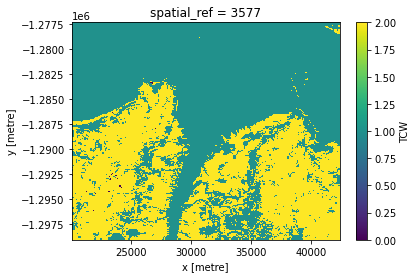

In [23]:
# print('Data in water seasonality',data)
# Calculate daily TCW
tcw = calculate_indices(data,
                        index='TCW', 
                        collection='ga_ls_3',
                        drop=True,
                        normalise=False)
# print('tcw',tcw)
# tcw.isel(time=1).TCW.plot()

# Calculate wet pixels - daily boolean 
wet = (tcw.TCW > -600).to_dataset()
# print('wet',wet)
# wet.isel(time=1).TCW.plot()

# Group by month - total number of observations
wet_month = wet.groupby('time.month').sum(dim='time')  
# print('wet_month',wet_month)
# wet_month.isel(month=2).TCW.plot()

# Now if at least one time was observed as wet make it 1 (end result is boolean per month)
wet_once = wet_month.TCW >= 1
# print('wet_once',wet_once) 
# wet_once.isel(month=2).plot()

# # Calculate total number of inundated months
# wet_months = wet_once.sum(dim='month')
# # print('wet months',wet_months)
# # wet_months.plot()

# reduce original array to 2D
# using max here but not important as we just want to use shape/attributes
wet_reduce = wet_once.max(dim='month')

# Make empty monthly array
watersea = copy.deepcopy(wet_reduce)
watersea.values = np.zeros_like(wet_reduce, dtype='float64')
# print('watersea',watersea)

# Get ready for consecutive count
wet_numpy = wet_once.values
empty_numpy = watersea.values

# Calculate consecutive counts
consec = consecutive_count(wet_numpy, empty_numpy, required_consecutive = 1)
# print('consec',consec.shape)
# plt.imshow(consec)
# plt.colorbar()

# create new data array with sampe dimensions as original
wet_summary = xr.DataArray(consec, coords=wet_reduce.coords, dims=wet_reduce.dims)
# print('wet_summary',wet_summary)
# wet_summary.plot()

# using wet_months to seperate Water < 3 months (<= 0.25) and Water > 3 months (> 0.25)
watersea.values = np.where(((wet_summary > 0) & (wet_summary <= 3)), 2, watersea.values)
watersea.values = np.where(((wet_summary > 3) & (wet_summary <= 12)), 1, watersea.values)
# print('watersea',watersea)
watersea.plot()

result = watersea.to_dataset(name='watersea_veg_cat').squeeze()
print('result',result)

In [21]:
watersea.values.shape

(218, 223)

In [22]:
wet_months.plot()

NameError: name 'wet_months' is not defined

### Works without consecutive bit

In [ ]:
# print('Data in water seasonality',data)
# Calculate daily TCW
tcw = calculate_indices(data,
                        index='TCW', 
                        collection='ga_ls_3',
                        drop=True,
                        normalise=False)
# print('tcw',tcw)
# tcw.isel(time=1).TCW.plot()

# Calculate wet pixels - daily boolean 
wet = (tcw.TCW > -600).to_dataset()
# print('wet',wet)
# wet.isel(time=1).TCW.plot()

# Group by month - total number of observations
wet_month = wet.groupby('time.month').sum(dim='time')  
# print('wet_month',wet_month)
# wet_month.isel(month=2).TCW.plot()

# Now if at least one time was observed as wet make it 1 (end result is boolean per month)
wet_once = wet_month.TCW >= 1
# print('wet_once',wet_once) 
# wet_once.isel(month=2).plot()

# Calculate total number of inundated months
wet_months = wet_once.sum(dim='month')
# print('wet months',wet_months)
# wet_months.plot()

watersea = copy.deepcopy(wet_months)

# Make empty monthly array
watersea.values = np.zeros_like(wet_months, dtype='float64')
# print('watersea',watersea)

# using wet_months to seperate Water < 3 months (<= 0.25) and Water > 3 months (> 0.25)
watersea.values = np.where(((wet_months > 0) & (wet_months <= 3)), 2, watersea.values)
watersea.values = np.where(((wet_months > 3) & (wet_months <= 12)), 1, watersea.values)
print('watersea',watersea)
# watersea.plot()

result = watersea.to_dataset(name='watersea_veg_cat').squeeze()
print('result',result)

### Trash

In [ ]:
pv0 = gm.PV>0
pv0

In [ ]:
count_pv = pv0.sum(dim='time')
one_ob_pv = count >1
count_pv.plot()

In [ ]:
count_pv

In [ ]:
if count_pv == 1:
    # executing consecutive_count function
    rc = 1
    
elif count != 1:
    rc = 2

print(rc)

In [ ]:
npv0 = gm.NPV>0
count_npv = npv0.sum(dim='time')
one_ob_npv = count >1
count_npv.plot()

In [ ]:
bs0 = gm.BS>0
count_bs = bs0.sum(dim='time')
one_ob_bs = count >1
count_bs.plot()

In [ ]:
combo_one_ob = ((count_bs + count_pv + count_npv)==3)
combo_one_ob.plot()

### Make simplified monthly summaries

In [ ]:
data_month = gm.groupby('time.month').median(dim='time')   
data_month

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
# Create mask where PV > BS
PV_dominant = data_month['PV'] > data_month['BS']
PV_dominant_nan = PV_dominant.where((data_month['PV'] >= 0) & (data_month['BS'] >= 0))

NOTE: we now have monthy summaries

In [ ]:
plt.imshow(PV_dominant_nan.isel(month=0))

### Run consectutive count
- Takes in a numpy array (tv_numpy)
- Takes in an empty numpy array with same shape as tv_numpy
- Require consectutive is just a number (e.g. must be consecutive 2 times)

In [ ]:
tv_mask = PV_dominant_nan

# make values of 2 == 1 (end result in binary veg mask)
tv_mask_drop = np.where(tv_mask >=1, 1, 0)
tv_mask_xr = xr.DataArray(tv_mask_drop, coords=tv_mask.coords, dims=tv_mask.dims)
#print('tv_mask_xr',tv_mask_xr)

# Pull tv as numpy array
tv_numpy = tv_mask_xr.values
print('tv_numpy',tv_numpy.shape)

# we have made a binary multi-temporal array

In [ ]:
# Set up array for output (faster to pre-allocate for numba).
# Needs to be float32 for NaN
consecutive_numpy = np.empty((tv_numpy.shape[1], tv_numpy.shape[2]), dtype=np.float32)

In [ ]:
required_consecutive = 2

In [ ]:
# Run function to get array of with 1 where number of consecutive values for different
# dates is >= required_consecutive
consecutive_numpy = consecutive_count(tv_numpy, consecutive_numpy, required_consecutive)

In [ ]:
plt.imshow(consecutive_numpy)

### FC summary

Maybe I can do something where, if there is only one pixel, keep it, but if there is 2 keep that

In [ ]:
def consecutive_count(tv_numpy, consecutive_numpy, required_consecutive, consec_msk_val=1):
    '''
    function to get consective count of veg (1) for each pixel across the time series

    :param numpy.array tv_numpy: 3-D array of tv[z,y,x]
    :param numpy.array consecutive_numpy: bool output array for veg (1) and non veg (0)
    :param float required_consecutive: how many consectutive 1's to be classified as veg?
    :param float consec_msk_val: what value to calculcate consectutives on
           default is veg (1)     
    '''

    for y in range(tv_numpy.shape[1]):
        for x in range(tv_numpy.shape[2]):
            # If all the values are nan then just set output to nan and carry on",
            pixel = tv_numpy[:,y,x]

            if np.all(np.isnan(pixel)):
                consecutive_numpy[y,x] = np.nan
                continue            

            # get counts of consecutive veg classifications
            counts = [len(list(group)) for label, group in groupby(pixel[(~np.isnan(pixel))]) if label == 1]

            if not counts:
                consecutive_numpy[y,x] = 0
            elif max(counts) >= required_consecutive:
                consecutive_numpy[y,x] = 1
            else:
                consecutive_numpy[y,x] = 0

    return consecutive_numpy

In [ ]:
data_nan = masking.mask_invalid_data(data)

# Create water and low-quality fc masks
no_water = np.invert( (data['water'] == 128) | (data['water'] == 132) )
high_ue = (data['UE'] > 30) & no_water

# Set to null areas with high UE, but no water
data_nan = data_nan.where(np.invert(high_ue))

# Don't need this anymore
data_nan = data_nan.drop("UE")
del high_ue

# Where there's water, set PV to 0
data_nan['PV'] = data_nan.PV.where(no_water, 0)
data_nan['NPV'] = data_nan.NPV.where(no_water, 0)

# Where there's water, set BS to 100
data_nan['BS'] = data_nan.BS.where(no_water, 100)

# don't need this anymore
data_nan = data_nan.drop("water")
del no_water

data_month = data_nan.groupby('time.month').median(dim='time')    

# Create mask where PV > BS
PV_dominant = data_month['PV'] > data_month['BS']
PV_dominant_nan = PV_dominant.where((data_month['PV'] >= 0) & (data_month['BS'] >= 0))

# Create mask where NPV > BS
NPV_dominant = data_month['NPV'] > data_month['BS']
NPV_dominant_nan = NPV_dominant.where((data_month['NPV'] >= 0) & (data_month['BS'] >= 0))

# Veg where PV or NPV are greater than BS
tv_mask = (PV_dominant_nan + NPV_dominant_nan)

# make values of 2 == 1 (end result in binary veg mask)
tv_mask_drop = np.where(tv_mask == 2, 1, tv_mask)
tv_mask_xr = xr.DataArray(tv_mask_drop, coords=tv_mask.coords, dims=tv_mask.dims)

# executing consecutive_count function #
# veg = 2 consecutive months
required_consecutive = 2

# Pull tv as numpy array
tv_numpy = tv_mask_xr.values

# Set up array for output (faster to pre-allocate for numba).
# Needs to be float32 for NaN
consecutive_numpy = np.empty((tv_numpy.shape[1], tv_numpy.shape[2]), dtype=np.float32)

# Run function to get array of with 1 where number of consecutive values for different
# dates is >= required_consecutive
consecutive_numpy = self.consecutive_count(tv_numpy, consecutive_numpy, required_consecutive)

# reduce original array to 2D
# using max here but not important as we just want to use shape/attributes
tv_reduce = tv_mask.max(dim='month')

# create new data array with sampe dimensions as original
tv_summary = xr.DataArray(consecutive_numpy, coords=tv_reduce.coords, dims=tv_reduce.dims)  
return tv_summary.to_dataset(name='fc_veg')

### Apply salt index

Water and salt do not have similar index values, and salt is at extremes:
- SI2
- SI3
- SI4
- SI5
- SI6
- SI7
- SI10
- BI
- VSSI


In [ ]:
ds = gm

In [ ]:
# Salt index list:
ds['si1'] = ds['blue']/ds['red']
ds['si2'] = ds['blue']-(ds['red']/ds['blue'])+ds['red']
ds['si3'] = (ds['green']*ds['red'])/ds['blue']
ds['si4'] = np.sqrt(ds['red']*ds['blue'])
ds['si5'] = (ds['blue']*ds['red'])/ds['green']
ds['si6'] = (ds['red']*ds['nir'])/ds['green']
ds['si7'] = np.sqrt(ds['green']*ds['red'])
ds['si8'] = np.sqrt((ds['green']**2)*(ds['red']**2)*(ds['nir']**2))
ds['si9'] = np.sqrt((ds['green']**2)*(ds['red']**2))
ds['si10'] = (ds['nir']-ds['swir1'])/(ds['nir']+ds['swir1'])
ds['sr'] = ds['nir']/ds['red']
ds['ndsi'] = (ds['red']-ds['nir'])/(ds['red']+ds['nir'])
ds['sia'] = (ds['red']/ds['blue'])*100
ds['sit'] = (ds['red']/ds['nir'])*100
ds['bi'] = np.sqrt(ds['red']**2+ds['nir']**2)
ds['pd'] = ds['nir']/(ds['nir']+ds['red'])
ds['ipvi'] = ds['nir']/(ds['nir']+ds['red'])
ds['dvi'] = ds['nir']-ds['red']
ds['ndvi'] = (ds['nir']-ds['red'])/(ds['nir']+ds['red'])             
ds['cosri'] = ((ds['blue']+ds['green'])/(ds['red']+ds['nir']))*ds['ndvi']
ds['savi'] = 1.5*(ds['nir']+ds['red'])/(ds['nir']+ds['red']+0.5)
ds['evi'] = 2.5*((ds['nir']-ds['red'])/(ds['nir']+6*ds['red']-7.5*ds['blue']+1))
ds['gdvi'] = (ds['nir']**2-ds['red']**2)/(ds['nir']**2+ds['red']**2)
ds['msi'] = ds['swir1']/ds['nir']
ds['vssi'] =  2*ds['green']-5*(ds['red']+ds['nir'])

In [ ]:
(ds.si5.squeeze()).plot.imshow()

In [ ]:
# Keep salty areas
masked = gm.where(ds.si2>4000)
rgb(masked,bands=['red','green','blue'])

In [ ]:
rgb(gm,bands=['red','green','blue'])

In [ ]:
# Export

index_dict = ['si1','si2','si3','si4','si5','si6','si7','si8','si9','si10','sr','ndsi','sia','sit','bi','pd','ipvi','dvi','ndvi','cosri','savi','evi','gdvi','msi','vssi']
test_dict = ['si2','si3','si4','si5','si6','si7','si8','si9','si10','sit','bi','vssi']

for i in test_dict:
    dataset = ds[i].isel(time=0).to_dataset(name=i)
    write_geotiff('salt_indices/'+area_name+'_'+i+'.tif', dataset)